## Sentiment Analysis Classifier for Tweets

In this Jupyter Notebook, we'll be building a sentiment classifier to categorize tweets as either positive or negative. We will determine sentiment based on the token's positive and negative frequencies in the tweet corpus. Our dataset consists of sample tweets obtained from NLTK.

### Importing necessary packages and libraries

In [13]:
import nltk
nltk.download("punkt")
nltk.download('stopwords')
nltk.download('twitter_samples')
from nltk.corpus import stopwords 
from nltk.corpus import twitter_samples 

[nltk_data] Downloading package punkt to /home/huda/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/huda/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package twitter_samples to
[nltk_data]     /home/huda/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!


In [151]:
import numpy as np
import pandas as pd
import re
import string
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

## Importing Data

In this section, we are importing and reformatting the Twitter data for sentiment analysis. We begin by loading positive and negative tweets from JSON files and organizing them into DataFrames.

In [191]:
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

### Data Reformatting

Loading positive tweets, creates a DataFrame with columns for the tweet text and labels them as '1' for positive sentiment.

In [192]:
positive_tweets = pd.DataFrame(data=positive_tweets, columns=['tweet_text'])
positive_tweets['Label'] = 1
positive_tweets.head(2)

,tweet_text,Label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1


Lodaing negative tweets, creating DataFrame with tweet text and labels set to '0' for negative sentiment.

In [193]:
negative_tweets = pd.DataFrame(data=negative_tweets, columns=['tweet_text'])
negative_tweets['Label'] = 0
negative_tweets.head(2)

,tweet_text,Label
0,hopeless for tmr :(,0
1,Everything in the kids section of IKEA is so c...,0


Combining both positive and negative tweets into a single DataFrame for further analysis and classification.

In [194]:
tweets = pd.concat([positive_tweets,negative_tweets], axis=0)
tweets.head(2)

,tweet_text,Label
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1
1,@Lamb2ja Hey James! How odd :/ Please call our...,1


## TEXT PREPROCESSING

#### Text Cleaning Steps

1. **Stemming**:
   - word stemming using the Porter stemming algorithm. Stemming reduces words to their root form, helping in standardizing word variations.

2. **Stopwords Removal**:
   - Removing the most common words(stopwords) from the text.

3. **Tokenization**:
   - Tokenizing using the `TweetTokenizer` class from NLTK. This tokenizer is specifically designed for tweets and  it tokenize the tweet text while preserving case, reducing repeated characters, and stripping handles (e.g., "@username").

4. **Text Cleaning**:
   - Performing several text cleaning operations on the tweet text:
     - Removing "RT " (retweet indicator) from the beginning of the tweet.
     - Removing stock market ticker symbols (e.g., "$AAPL").
     - Removing hyperlinks (URLs) from the tweet.
     - Removing hashtags (#) from the tweet.

In [195]:
def process_tweet_text(tweet):
    stemmer = PorterStemmer()
    stop_words = stopwords.words('english')
    tokenizer = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)
    
    # removing symbols, tikers, hyoerlinks etc.
    tweet = re.sub(r'^RT[\s]', '', tweet)
    tweet = re.sub(r'\$\w*', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    
    #tokenizing
    tokens = tokenizer.tokenize(tweet)
    
    tweet_clean = [stemmer.stem(word) for word in tokens if (word not in stop_words and word not in string.punctuation)]
    
    return tweet_clean

Applying the `process_tweet_text` function to tokenize and preprocess the tweet text in the `tweets` DataFrame. The goal is to create a new column called 'tokens,' which will contain lists of individual tokens for each tweet.

In [198]:
tweets['tokens'] = tweets.tweet_text.apply(process_tweet_text)
tweets.head(5)

## BUILDING FREQUENCY TABLE

Calculating the frequency of tokens in both positive and negative tweets to understand which words are more common in each sentiment category.

In [200]:
freq = {}

for i in tweets.itertuples():
    _, _, label, tokens = i
    
    for token in tokens:
        pair = (token, label)
        if pair in freq:
            freq[pair] += 1
        else:
            freq[pair] = 1

In [201]:
len(freq)

13065

# Visualizing some tokens w.r.t their frequencies

Visualizing the frequencies of selected tokens in both positive and negative tweets. The goal is to gain insights into how these tokens are distributed across sentiment categories.

In [202]:
keys = ['happi', 'sad', 'fine', 'good', 'bad', 'mad', 'best', ':)', ':(', '😒', '😬', '😄', '😍',
        'song', 'idea', 'power', 'play']

In [203]:
data = []

for word in keys:
    pos_occur = 0
    neg_occur = 0
    
    pos_pair = (word, 1)
    neg_pair = (word,0)
    
    if pos_pair in freq:
        pos_occur = freq[pos_pair]
    
    if neg_pair in freq:
        neg_occur = freq[neg_pair]
    
    data.append((word, pos_occur, neg_occur))

/usr/lib/python3/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128556 (\N{GRIMACING FACE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


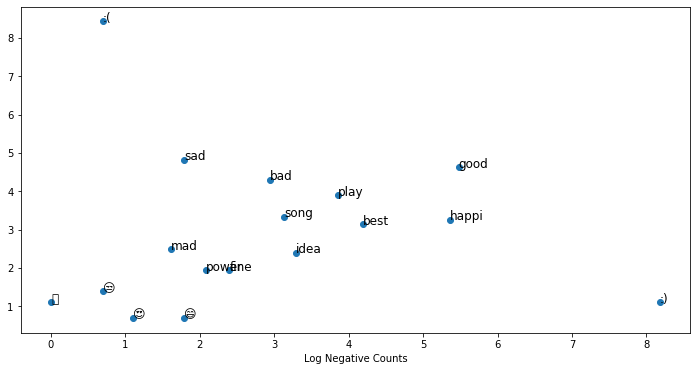

In [204]:
plt.figure(figsize=(12,6))

x = np.log([x[1] + 1 for x in data])  
y = np.log([x[2] + 1 for x in data]) 

plt.scatter(x, y)

for i in range(0, len(data)):
    plt.annotate(data[i][0], (x[i], y[i]), fontsize=12)

plt.xlabel('Log Positive Counts')
plt.xlabel('Log Negative Counts')
plt.show()

### Feature Extraction

Extracting features from a list of tokens. The features represent the frequency of positive and negative sentiment-associated tokens in the input token list.

In [236]:
def extract_features(tokens_list):
    pos_occur = 0
    neg_occur = 0
    for token in tokens_list:
        pos_pair = (token, 1)
        neg_pair = (token,0)
        if pos_pair in freq:
            pos_occur += freq[pos_pair]

        if neg_pair in freq:
            neg_occur += freq[neg_pair]
    
    return pd.Series([pos_occur, neg_occur])

Applying the `extract_features` function to extract token frequency features from the 'tokens' column in the `tweets` DataFrame.
Creating two new columns, 'pos_freq' and 'neg_freq,' to store the counts of positive and negative sentiment-associated tokens for each tweet.

In [243]:
tweets[['pos_freq','neg_freq']] = tweets.tokens.apply(extract_features)
tweets.head()

,tweet_text,Label,tokens,pos_freq,neg_freq
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1,"[followfriday, top, engag, member, commun, wee...",3764,72
1,@Lamb2ja Hey James! How odd :/ Please call our...,1,"[hey, jame, odd, :/, pleas, call, contact, cen...",4464,517
2,@DespiteOfficial we had a listen last night :)...,1,"[listen, last, night, :), bleed, amaz, track, ...",3759,160
3,@97sides CONGRATS :),1,"[congrat, :)]",3589,4
4,yeaaaah yippppy!!! my accnt verified rqst has...,1,"[yeaaah, yipppi, accnt, verifi, rqst, succeed,...",3915,280


### Train Test Split

In [244]:
X = tweets[['pos_freq', 'neg_freq']]
y = tweets['Label']

In [245]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=101, shuffle=True)

# Data Standardizing

Standardizing the feature data using the `StandardScaler`. Standardization ensures that each feature has a mean of 0 and a standard deviation of 1 in the training da

In [246]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Logistic Regression Classifier

In [247]:
clf = LogisticRegression()
clf.fit(X_train, y_train)

LogisticRegression()

In [248]:
preds = clf.predict(X_test)

Printing a classification report to evaluate the classifier's performance on the test set. The classification report includes metrics such as precision, recall, F1-score, and accuracy for both positive (1) and negative (0) sentiment labels.

In [249]:
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1253
           1       0.98      1.00      0.99      1247

    accuracy                           0.99      2500
   macro avg       0.99      0.99      0.99      2500
weighted avg       0.99      0.99      0.99      2500



### Predictions

Defining a function called `predict_tweet` that takes a tweet as input and predicts its sentiment (positive or negative) using a pre-trained logistic regression classifier.

In [266]:
def predict_tweet(tweet, freq, clf, std_scaler):
    tokenized_tweet = process_tweet_text(tweet)
    features = extract_features(tokenized_tweet)
    features = pd.DataFrame(features).T
    features.columns = ['pos_freq','neg_freq']
    scaled_features = std_scaler.transform(features)
    sentiment = clf.predict(scaled_features)[0]
    if sentiment == 1:
        return 'Positive Sentiment'
    return 'Negative Sentiment'

#### Examples

In [267]:
predict_tweet("i am fine", freq, clf, scaler)

'Positive Sentiment'

In [270]:
predict_tweet("Oh, because using Comic Sans in your PowerPoint presentation really says 'I'm a design genius.' 🙄 #DesignGoals #GraphicDesignMastermind", freq, clf, scaler)

'Negative Sentiment'

# VADER SENTIMENT ANALYSIS

In this section, we use the VADER sentiment analysis tool from NLTK to analyze the sentiment of tweets and evaluate the performance of the sentiment analysis model.

In [272]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/huda/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [273]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [274]:
sid = SentimentIntensityAnalyzer()

In [276]:
tweets['sentiment_scores'] = tweets.tweet_text.apply(lambda x:sid.polarity_scores(x)['compound'])
tweets.head(2)

,tweet_text,Label,tokens,pos_freq,neg_freq,sentiment_scores
0,#FollowFriday @France_Inte @PKuchly57 @Milipol...,1,"[followfriday, top, engag, member, commun, wee...",3764,72,0.7579
1,@Lamb2ja Hey James! How odd :/ Please call our...,1,"[hey, jame, odd, :/, pleas, call, contact, cen...",4464,517,0.6229


In [277]:
tweets['vader_label'] = tweets.sentiment_scores.apply(lambda x: 1 if x>=0 else 0)

In [279]:
print(classification_report(tweets.Label, tweets.vader_label))

              precision    recall  f1-score   support

           0       0.95      0.71      0.81      5000
           1       0.77      0.96      0.85      5000

    accuracy                           0.83     10000
   macro avg       0.86      0.83      0.83     10000
weighted avg       0.86      0.83      0.83     10000



# Conclusion

In this sentiment analysis notebook, we evaluated the performance of two sentiment classification approaches: one using a custom-built logistic regression model and the other using the VADER sentiment analysis tool.

- The custom-built logistic regression model exhibits good performance with high precision, recall, and F1-scores for both positive and negative sentiment. It achieves an accuracy of 99%.

- The VADER sentiment analysis tool performs reasonably well, particularly in identifying positive sentiment, where it achieves a high recall. However, it exhibits lower precision and recall for negative sentiment, resulting in an accuracy of 83%. 

`THE END`